### Recomputing these response vectors from the .pickle
- the code is just modified from the original notebook to reflect loading unit spiketrains from the .pickle.zip file

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
os.nice(1) 

1

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

/tmp/ipykernel_86931/2156191148.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from datetime import datetime

In [5]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    get_spike_train_vector
)

In [6]:
from cdcp.spiketrain_analysis.unit_stats.cued_similarity_and_spikevector_differences import (
    compute_cued_average_sm_rv_differences
)

In [7]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [8]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    ('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    ('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    ('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    ('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [9]:
min_playbacks = 1000

In [10]:
import pandas as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter1d

from sklearn.metrics.pairwise import (
    cosine_similarity,
    euclidean_distances,
    manhattan_distances,
)

In [23]:
def get_spike_train_vector(
    row,
    nbins=100,
    gaussian_sigma_ms=5,
    return_gauss=False,
    no_cue=True,
    padding_s = 0.1,
    mode="constant",
):
    """
    From a list of rows, create a gaussian smoothed spike impulse vector

    Parameters
    ----------
    row : [type]
        [description]
    gaussian_sigma : int, optional
        [description], by default 5
    nbins : int, optional
        [description], by default 100
    gaussian_sigma_ms : int, optional
        [description], by default 5
    return_gauss : bool, optional
        [description], by default False

    Returns
    -------
    [type]
        [description]
    """
    
    if len(row.spike_times) == 0:
        return np.zeros(nbins)
    
    bin_ms = 1000 / nbins
    gaussian_sigma = gaussian_sigma_ms / bin_ms
    padding_bins = int(padding_s*nbins)
    if padding_bins - padding_s*nbins != 0:
        raise ValueError('nbins incompatible with padding')    
    if no_cue:
        if row.cue in ["CL1", "CL0", "CN", "CR0", "CR1"]:
            bins = np.linspace(1-padding_s, 2+padding_s, nbins + 1 + padding_bins*2)
        else:
            bins = np.linspace(0-padding_s, 1+padding_s, nbins + 1+ padding_bins*2)
    else:
        if row.cue in ["CL1", "CL0", "CN", "CR0", "CR1"]:
            bins = np.linspace(0-padding_s, 2-padding_s, nbins * 2 + 1+ padding_bins*2)
        else:
            bins = np.linspace(-1-padding_s, 1-padding_s, nbins * 2 + 1+ padding_bins*2)

    hist = np.histogram(row.spike_times, bins, density=False)[0]
    if padding_bins>0:
        hist = hist[padding_bins:-padding_bins]

    if return_gauss:
        gauss_convolved_psth = gaussian_filter1d(
            hist.astype("float"), gaussian_sigma, mode=mode
        )
        return gauss_convolved_psth
    else:
        return hist

In [24]:
def get_unit_spike_trains(
    unit_recording_ids,
    spikesorting_folder,
    sorter,
    unit,
    bird,
    save_folder="trial_aligned_spikes",
):
    trial_aligned_spikes_list = []
    for unit, recording_id in tqdm(
        unit_recording_ids, desc="unit spike trains", leave=False
    ):
        trial_aligned_spikes_loc = (
            DATA_DIR
            / "spikesorting"
            / save_folder
            / bird
            / recording_id
            / "{}.pickle.zip".format(unit)
        )
        if trial_aligned_spikes_loc.exists():
            trial_aligned_spikes = pd.read_pickle(trial_aligned_spikes_loc)
            trial_aligned_spikes["recording_id"] = recording_id

            trial_aligned_spikes["stim"] = [
                i[:-4] if i[-4:].lower() == ".wav" else i
                for i in trial_aligned_spikes.stim.values
            ]

            mask = [
                (i.split("_")[-1].isnumeric() and len(i.split("_")[-1]) == 3)
                for i in trial_aligned_spikes.stim.values
            ]

            # get cue info
            trial_aligned_spikes["cue"] = [
                i.split("_")[0] if mask else np.nan
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]
            trial_aligned_spikes["interp"] = [
                i.split("_")[1] if mask else np.nan
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]

            # for i, m in zip(trial_aligned_spikes.stim.values, mask):
            #    if m:
            #        int(i.split("_")[2])
            trial_aligned_spikes["interp_point"] = [
                np.nan if m == False else int(i.split("_")[2])
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]
            trial_aligned_spikes_list.append(trial_aligned_spikes)
        else:
            0
            # print("{} does not have trial aligned spikes yet".format(recording_id))
            # print("\t", trial_aligned_spikes_loc)
    if len(trial_aligned_spikes_list) < 1:
        #breakme
        return None
    else:
        return pd.concat(trial_aligned_spikes_list)

### Compute spike vectors and statistics

In [25]:
n_time_bins = 100
identifier = "response_vector_25ms_{}".format(n_time_bins)

In [26]:
def get_unit_statistic(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    bird,
    identifier=identifier,
    recompute=False,
    parallel=True,
    n_time_bins=100,
    gaussian_sigma_ms=25,
    save=True,
    plot=False,
):
    def run():

        unit_series_save_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.npy".format(unit_to_analyze.cluster_id)
        )

        # check if we need to run everything
        if unit_series_save_loc.exists() and (recompute is False):
            print("stat already exists")
            return

        # make sure folder exists
        ensure_dir(unit_series_save_loc)

        unit_series_list = []
        # load spike trains
        trial_aligned_spikes = get_unit_spike_trains(
            unit_to_analyze.sort_units,
            spikesorting_folder,
            sorter,
            unit_to_analyze,
            bird=bird,
            save_folder="trial_aligned_spikes_padding_100ms",
        )
        if trial_aligned_spikes is None:
            # breakme
            # because there are not enough spikes for this unit to be worth it
            print("no trial_aligned_spikes")
            return

        # get vectors
        spike_vectors = [
            get_spike_train_vector(
                row,
                nbins=n_time_bins,
                return_gauss=True,
                gaussian_sigma_ms=gaussian_sigma_ms,
            )
            for idx, row in tqdm(
                trial_aligned_spikes.iterrows(),
                total=len(trial_aligned_spikes),
                desc="spike vectors",
                leave=False,
            )
        ]
        if save:
            np.save(unit_series_save_loc, np.array(spike_vectors))

        return

    if parallel == False:
        run()
    else:
        try:
            run()
        except Exception as e:
            with open("error_log.txt", "w") as text_file:
                text_file.write(str(e))
            raise ValueError(unit_to_analyze.cluster_id)

  0%|          | 0/14 [00:00<?, ?it/s]

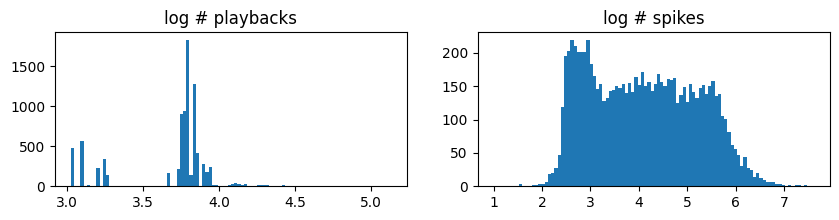

B1597 total # merged units: 8711


In [34]:
for bird, timestamp, sorter in tqdm(birds):
    spikesorting_folder = (DATA_DIR
                / "spikesorting"
                / bird
                / timestamp)
    # get the summary of recordings for the bird
    recording_summary_df = pd.read_pickle(
        DATA_DIR / "spikesorting" / "recording_df" / f"{bird}.pickle.zip"
    )

    # get units that are to be merged
    merged_units = pd.read_pickle(
            DATA_DIR / "spikesorting" / "unit_clusters" / f"{bird}.pickle.zip"
        )
    merged_units = merged_units.sort_values(by='n_playbacks', ascending=False)
    merged_units = merged_units[merged_units.n_playbacks.astype('float')  > min_playbacks]
    
    plot = True
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10,2))
        axs[0].hist(np.log10(merged_units.n_playbacks.values.astype('float')+1), bins = 100);
        axs[0].set_title('log # playbacks')
        axs[1].hist(np.log10(merged_units.n_spikes.values.astype('float')+1), bins = 100);
        axs[1].set_title('log # spikes')
        plt.show()
        print('{} total # merged units: {}'.format(bird, len(merged_units)))
    break
    ensure_dir(spikesorting_folder / 'unit_statistics' / statistics_timestamp)
    Parallel(n_jobs = -1, verbose=10)(
        delayed(get_unit_statistic)(
            unit_to_analyze,
            spikesorting_folder,
            statistics_timestamp,
            bird = bird,
            recompute=True,
            parallel=True,
            n_time_bins = n_time_bins
            
                    )
        for uniti, unit_to_analyze in tqdm(
            merged_units.iterrows(), desc="unit", total=len(merged_units)
        )
    );

### Debugging

In [18]:
breakme

NameError: name 'breakme' is not defined

In [38]:
for uniti, unit_to_analyze in tqdm(
        merged_units[:]
        .iterrows(), desc="unit", total=len(merged_units)
    ):
    get_unit_statistic(
        unit_to_analyze,
        spikesorting_folder,
        statistics_timestamp,
        bird=bird,
        recompute=True,
        parallel=False,
        save=True,
        plot=False,
    )
    break

unit:   0%|          | 0/8711 [00:00<?, ?it/s]

unit spike trains:   0%|          | 0/33 [00:00<?, ?it/s]

spike vectors:   0%|          | 0/93739 [00:00<?, ?it/s]

In [39]:
unit_series_save_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.npy".format(unit_to_analyze.cluster_id)
        )

In [ ]:
%debug

In [ ]:
??get_unit_spike_trains

In [ ]:
merged_units[:3]

In [ ]:
recording_id = 

In [ ]:
(spikesorting_folder
            / "trial_aligned_spikes_padding_100ms"
            / sorter
            / "exp1_rec1_dat2021-07-20_23-18-06")

In [ ]:
!ls /mnt/cube/tsainbur/Projects/github_repos/cdcp_chronic/data/spikesorting/B1459/2021-08-26_21-21-12_755614/trial_aligned_spikes_padding_100ms/kilosort2_5/exp1_rec1_dat2021-07-20_17-15-11